In [1]:
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt

D:\miniconda3\envs\cnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.ConvBlock = nn.Sequential(
#             input_shape: [3x227x227]
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),                # output_shape:[96x55x55]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                                              # output_shape:[96x27x27]
            
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),    # output_shape:[256x27x27]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                                              # output_shape:[256x13x13]

            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),   # output_shape:[384x13x13]
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),   # output_shape:[384x13x13]
            nn.ReLU(),

            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),   # output_shape:[256x13x13]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),                                              # output_shape:[256x6x6]
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()


    def init_bias(self):
        for layer in self.ConvBlock:
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)

    def forward(self, x):
        x = self.ConvBlock(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [3]:
transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
    transforms.Resize((227, 227), interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616]),
])

In [4]:
train_dataset = datasets.CIFAR10(root='../data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='../data', train=False, transform=transform, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=256, shuffle=False)

In [6]:
def show_images(data_loader, classes):
    images, labels = next(iter(data_loader))
    images = images.numpy().transpose((0, 2, 3, 1)) # matplotlib显示图像时通常期望的维度顺序是(height, width, channels)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for index in range(len(labels)):
        ax = axes[index]
        ax.imshow(images[index])
        ax.axis('off')
        ax.set_title(classes[labels[index]])
        
    plt.show

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

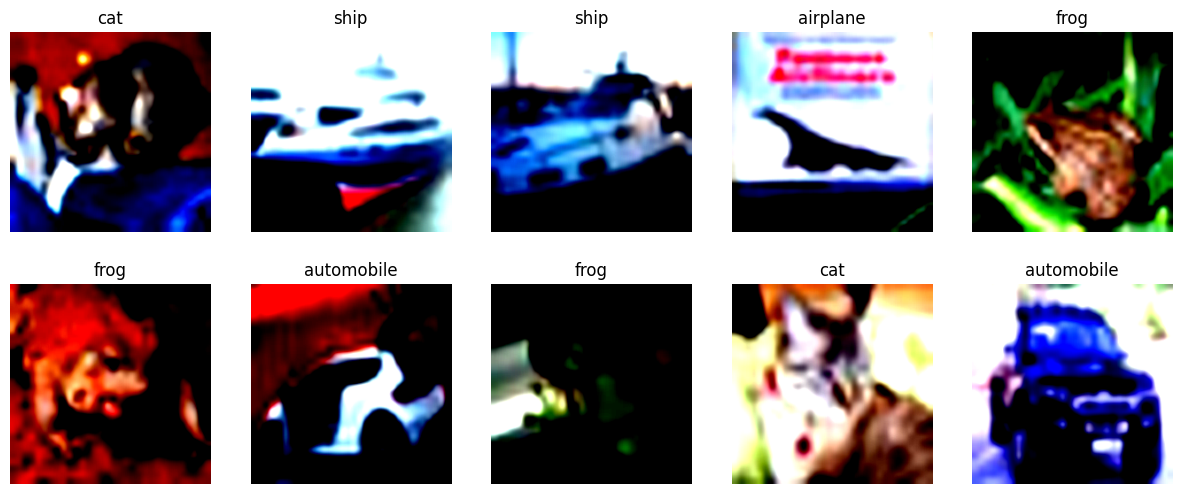

In [7]:
data_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=10)
classes = test_dataset.classes
show_images(data_loader, classes)

In [8]:
model = AlexNet(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=5e-4)
# optimizer = optim.Adam(model.parameters())

In [9]:
train_loss, train_acc, test_loss, test_acc = [], [], [], []
best_val_loss = float('inf')
save_path = './AlexNet.pth'

In [10]:
num_epochs = 20
for epoch in tqdm(range(num_epochs)):
    model.train()
    temp_loss, temp_correct = 0, 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        _, predicted = torch.max(outputs.data, 1)
        temp_correct += (predicted == labels).sum().item()
        temp_loss += loss
    print('Epoch {}|{}, Train Loss:{:.4f}, Train Acc:{:.2f}%'.format(epoch+1, num_epochs, temp_loss/len(train_loader), temp_correct/len(train_dataset) * 100))
    train_loss.append(temp_loss/len(train_loader))
    train_acc.append(temp_correct/len(train_dataset))
    
    temp_loss, temp_correct = 0, 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            temp_correct += (predicted == labels).sum().item()
            temp_loss += loss
    print('Epoch {}|{}, Test Loss:{:.4f}, Test Acc:{:.2f}%'.format(epoch+1, num_epochs, temp_loss/len(test_loader), temp_correct/len(test_dataset) * 100))
    test_loss.append(temp_loss/len(test_loader))
    test_acc.append(temp_correct/len(test_dataset))
    
    if temp_loss < best_val_loss:
        best_val_loss = temp_loss
        torch.save(model.state_dict(), save_path)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1|20, Train Loss:1.9657, Train Acc:26.47%
Epoch 1|20, Test Loss:1.5608, Test Acc:42.99%


  5%|████                                                                              | 1/20 [01:58<37:31, 118.51s/it]

Epoch 2|20, Train Loss:1.4105, Train Acc:48.97%
Epoch 2|20, Test Loss:1.1874, Test Acc:57.26%


 10%|████████▏                                                                         | 2/20 [03:55<35:14, 117.46s/it]

Epoch 3|20, Train Loss:1.0991, Train Acc:61.01%
Epoch 3|20, Test Loss:1.1050, Test Acc:61.24%


 15%|████████████▎                                                                     | 3/20 [05:50<33:00, 116.47s/it]

Epoch 4|20, Train Loss:0.8813, Train Acc:69.39%
Epoch 4|20, Test Loss:0.8449, Test Acc:70.78%


 20%|████████████████▍                                                                 | 4/20 [07:50<31:24, 117.78s/it]

Epoch 5|20, Train Loss:0.7330, Train Acc:74.77%
Epoch 5|20, Test Loss:0.7645, Test Acc:74.02%


 25%|████████████████████▌                                                             | 5/20 [09:47<29:21, 117.46s/it]

Epoch 6|20, Train Loss:0.6127, Train Acc:78.80%
Epoch 6|20, Test Loss:0.6972, Test Acc:76.38%


 30%|████████████████████████▌                                                         | 6/20 [11:46<27:35, 118.23s/it]

Epoch 7|20, Train Loss:0.5269, Train Acc:81.63%


 35%|████████████████████████████▋                                                     | 7/20 [13:47<25:46, 118.94s/it]

Epoch 7|20, Test Loss:0.7192, Test Acc:76.72%
Epoch 8|20, Train Loss:0.4351, Train Acc:84.99%
Epoch 8|20, Test Loss:0.5968, Test Acc:79.69%


 40%|████████████████████████████████▊                                                 | 8/20 [15:48<23:57, 119.76s/it]

Epoch 9|20, Train Loss:0.3622, Train Acc:87.43%


 45%|████████████████████████████████████▉                                             | 9/20 [17:51<22:06, 120.56s/it]

Epoch 9|20, Test Loss:0.6310, Test Acc:80.32%
Epoch 10|20, Train Loss:0.2797, Train Acc:90.26%


 50%|████████████████████████████████████████▌                                        | 10/20 [19:50<20:02, 120.30s/it]

Epoch 10|20, Test Loss:0.6984, Test Acc:79.52%
Epoch 11|20, Train Loss:0.2266, Train Acc:92.12%


 55%|████████████████████████████████████████████▌                                    | 11/20 [21:53<18:08, 120.93s/it]

Epoch 11|20, Test Loss:0.6749, Test Acc:79.89%
Epoch 12|20, Train Loss:0.1810, Train Acc:93.83%


 60%|████████████████████████████████████████████████▌                                | 12/20 [23:53<16:06, 120.84s/it]

Epoch 12|20, Test Loss:0.7177, Test Acc:80.76%
Epoch 13|20, Train Loss:0.1453, Train Acc:95.03%


 65%|████████████████████████████████████████████████████▋                            | 13/20 [25:55<14:07, 121.07s/it]

Epoch 13|20, Test Loss:0.7649, Test Acc:80.88%
Epoch 14|20, Train Loss:0.1112, Train Acc:96.17%


 70%|████████████████████████████████████████████████████████▋                        | 14/20 [27:56<12:05, 120.98s/it]

Epoch 14|20, Test Loss:0.8006, Test Acc:81.17%
Epoch 15|20, Train Loss:0.0915, Train Acc:96.94%


 75%|████████████████████████████████████████████████████████████▊                    | 15/20 [29:55<10:01, 120.35s/it]

Epoch 15|20, Test Loss:0.7697, Test Acc:81.51%
Epoch 16|20, Train Loss:0.0807, Train Acc:97.28%


 80%|████████████████████████████████████████████████████████████████▊                | 16/20 [31:58<08:04, 121.18s/it]

Epoch 16|20, Test Loss:0.7825, Test Acc:81.38%
Epoch 17|20, Train Loss:0.0736, Train Acc:97.58%


 85%|████████████████████████████████████████████████████████████████████▊            | 17/20 [33:56<06:01, 120.44s/it]

Epoch 17|20, Test Loss:0.8427, Test Acc:81.62%
Epoch 18|20, Train Loss:0.0671, Train Acc:97.79%


 90%|████████████████████████████████████████████████████████████████████████▉        | 18/20 [35:55<03:59, 119.99s/it]

Epoch 18|20, Test Loss:0.8428, Test Acc:81.61%
Epoch 19|20, Train Loss:0.0525, Train Acc:98.32%


 95%|████████████████████████████████████████████████████████████████████████████▉    | 19/20 [37:56<02:00, 120.32s/it]

Epoch 19|20, Test Loss:0.8730, Test Acc:81.87%
Epoch 20|20, Train Loss:0.0420, Train Acc:98.66%


100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [39:57<00:00, 119.87s/it]

Epoch 20|20, Test Loss:0.9308, Test Acc:80.80%


In [18]:
train_loss = [float(loss) for loss in train_loss]
print(train_loss)
test_loss = [float(loss) for loss in test_loss]
print(test_loss)

[1.9656918048858643, 1.4104548692703247, 1.0991042852401733, 0.8812721967697144, 0.7330406308174133, 0.6126781702041626, 0.5269432067871094, 0.43505460023880005, 0.3622489273548126, 0.279727041721344, 0.22657746076583862, 0.1809762865304947, 0.14526893198490143, 0.11117266118526459, 0.09148270636796951, 0.08067851513624191, 0.07356754690408707, 0.06708955019712448, 0.05254192650318146, 0.04200056195259094]
[1.5608023405075073, 1.1874455213546753, 1.1050045490264893, 0.844882607460022, 0.7645055651664734, 0.6972063779830933, 0.7192241549491882, 0.5967602133750916, 0.630958616733551, 0.6983922123908997, 0.6748814582824707, 0.7176944613456726, 0.7648866176605225, 0.8005799651145935, 0.7697038054466248, 0.7825059294700623, 0.8426515460014343, 0.8428034782409668, 0.8729982376098633, 0.9307648539543152]


In [19]:
df = pd.DataFrame({
    'train_loss': train_loss,
    'train_acc': train_acc,
    'test_loss': test_loss,
    'test_acc': test_acc
})
df.to_csv('experiment.csv', index=False)

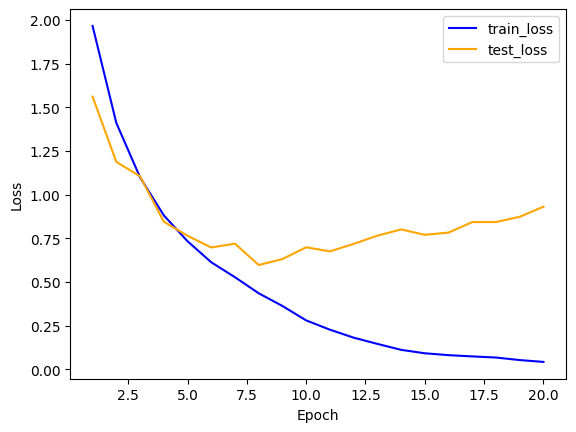

In [30]:
from matplotlib.ticker import FuncFormatter
epoch = [i+1 for i in range(num_epochs)]
plt.plot(epoch, train_loss, color='blue', label='train_loss')
plt.plot(epoch, test_loss, color='orange', label='test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()